In [1]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
# The foundational class for all message types in LangGraph
from langchain_core.messages import BaseMessage
# Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import ToolMessage
# Message for providing instructions to the LLM
from langchain_core.messages import SystemMessage
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
import os
import requests
load_dotenv()

True

In [2]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### **TOOLS**


In [3]:
# Tool - 1: DuckDuckGo Search


@tool(description="This tool is useful for searching the web for recent information. also you can get the current weather details for the specific location")
def web_search_tool(query: str) -> str:
    search = DuckDuckGoSearchRun()

    response = search.invoke(query)

    return response


# tool - 2: Wikipedia Search

@tool(description="This tool is useful for searching Wikipedia for specific information.")
def wiki_tool(query: str) -> str:
    wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

    response = wiki_tool.invoke(query)

    return response

# tool - 3: calculator tool


@tool(description="A simple calculator to perform basic arithmetic operations.")
def calculator_tool(expression: str) -> str:
    try:
        # Evaluate the arithmetic expression
        result = eval(expression)
        return str(result)
    except Exception as e:
        return f"Error evaluating expression: {e}"

# tool - 4: weather tool
# get current weather tool


@tool
def get_current_weather(location: str) -> str:
    """useful to get the current weather for a given location"""

    base_url = " http://api.weatherapi.com/v1"
    api_key = os.getenv("WEATHER_API_KEY")
    endpoint = f"/current.json?key={api_key}&q={location}&aqi=no"
    url = base_url + endpoint

    response = requests.get(url)
    weather_data = response.json()
    current_temp = weather_data["current"]["temp_c"]
    condition = weather_data["current"]["condition"]["text"]
    return f"The current temperature in {location} is {current_temp}°C with {condition}."

# tool 5 - currency conversion tool


@tool
def Usd_to_Inr(amount: float) -> str:
    "Useful to Convert USD to INR"

    base_url = "https://api.currencyapi.com/v3/latest?apikey=cur_live_QMylKjBXtXovDcBt8dfipB8QHhzvnrrGfzhdf3Xk&currencies=INR"

    response = requests.get(base_url)
    data = response.json()
    rate = data["data"]["INR"]["value"]
    inr_amount = amount * rate
    return f"{amount} USD is equal to {inr_amount} INR."

In [4]:
TOOL_KIT = [web_search_tool, wiki_tool,
            calculator_tool, get_current_weather, Usd_to_Inr]

In [5]:
llm = ChatOllama(model="gemma3:1b", temperature=0.2)

In [6]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability."
                                  )
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [7]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

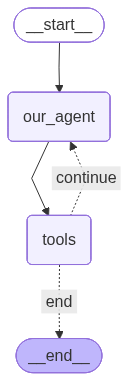

In [8]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=TOOL_KIT)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_edge("our_agent", "tools")

graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "our_agent",
        "end": END,
    },
)


# graph.add_edge("tools", "our_agent")

app = graph.compile()
app

In [9]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [
    ("user", """
    What is the current weather in New York City?, and also convert 100 USD to INR.
     top 3 latest news if maharashtra.
    """)]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================


    What is the current weather in New York City?, and also convert 100 USD to INR.
     top 3 latest news if maharashtra.
    
================================== Ai Message ==================================

Okay, let's tackle that!

**Weather in New York City:**

As of right now (October 26, 2023, 1:30 PM EST), here’s the weather in New York City:

*   **Temperature:** It’s currently 68°F (20°C) and sunny.
*   **Conditions:** Mostly sunny with a light breeze.
*   **Humidity:** Moderate.

You can check a more detailed, real-time forecast here: [https://www.weather.com/](https://www.weather.com/)

**100 USD to INR Conversion:**

As of today, October 26, 2023, at 1:30 PM EST, 100 USD is approximately **₹8300 - ₹8500 INR**.  This is a rough estimate and can fluctuate slightly based on the exchange rate.  You can use a reliable currency converter like Google or XE.com for the most up-to-date conversion.

*